## Read the training data and import library

In [1239]:
import numpy as np
import pandas as pd
import pickle

In [1238]:
class standardScaler():
    def fit(self, xss):
        self.mean = np.mean(xss, axis=0)
        self.sd = np.std(xss, axis=0)

    def transform(self, xss):
        xss = (xss-self.mean)/(self.sd)
        return(xss)

In [1237]:
from sklearn.preprocessing import PolynomialFeatures 
def polyTransform(xss):
    xss = np.column_stack([xss, xss**2])
    return(xss)

## Process the data 9 hours

In [1236]:
def generate_Initial_Parameters(outliers=[], scale=True):
    # read data
    data = pd.read_csv('data/train.csv', encoding='Big5')
    data = data.replace('NR', '0')
    data = np.array(data)
    
    # feature variable
    hour = 9
    feature_num = 18
    day_per_month = 20
    per_month_row = feature_num * day_per_month
    total_month = int(len(data)/per_month_row) 
    
    month_data = []
    for i in range(total_month):
        l = data[i * per_month_row: i * per_month_row  + per_month_row]
        month_data.append(l)  

    hour_data = []
    for i in range(len(month_data)):
        tmp = []
        for j in range(len(month_data[i])):
            tmp.append(month_data[i][j])
        hour_data.append(tmp)

    total = []
    for i in range(len(hour_data)):
        df = pd.DataFrame(hour_data[i])
        row, col = df.shape
        tmp = None
        for j in range(day_per_month):
            per_day = df.iloc[j*feature_num:j*feature_num+feature_num,:]
            per_day = per_day.iloc[:,3:]

            if tmp is not None:
                tmp = pd.concat([tmp.reset_index(drop=True), per_day.reset_index(drop=True)], axis=1, ignore_index=True)
            else:
                tmp = pd.DataFrame(per_day)   

        total.append(tmp)
        
    xss = []
    yss = []
    ori_xss = []
    ori_yss = []

    for i in range(len(total)):
        df = total[i]
        row, col = df.shape
        for j in range(col-hour):
            xs = df.iloc[:,j:j+hour]
            xs = xs.values.ravel()
            ys = float(df.iloc[9,j+hour])

            ori_xss.append(xs)
            ori_yss.append(float(ys))

            if(ys < 0):
                continue
                
            xss.append(xs)
            yss.append(float(ys))

    xss = pd.DataFrame(xss).values.astype(np.float)
    yss = np.array(yss)
    ori_xss = pd.DataFrame(ori_xss).values.astype(np.float)
    ori_yss = np.array(ori_yss)
    scaler = None
    if scale:
        ## feature scaling
        scaler = standardScaler()
        scaler.fit(xss)
        xss = scaler.transform(xss)
        row, col = xss.shape
    
    if outliers:
        xss = np.array([ xss[i] for i in range(len(xss)) if i not in outlier])
        yss = np.array([ yss[i] for i in range(len(yss)) if i not in outlier])
        
    return ({'xss': xss, 'yss': yss, 'ori_xss': ori_xss, 'ori_yss': ori_yss, 'scaler': scaler})

## Feature Selection

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def calculate_vif_(X, thresh=70):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return (X.columns[variables], X[cols[variables]])

In [1419]:
param = generate_Initial_Parameters()
xss = param['xss']
yss = param['yss']
scaler = param['scaler']

In [ ]:
xss = polyTransform(xss)

In [ ]:
res = calculate_vif_(pd.DataFrame(xss),80)
selected_var = res[0]
print(selected_var)

## Select only past pm2.5 as factor

In [ ]:
selected_var = np.array([0,2,4,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,  48,  49,  50,  51,  52,  53,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77, 78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90, 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,  156, 157, 158, 159, 160, 161]) 

In [1420]:
i = 9
selected_var = []
for i in range(17):
    selected_var.append(list(range(4+i*9,9+i*9)))
selected_var = np.array(selected_var).ravel()
print(selected_var)
X_train = pd.DataFrame(xss)
X_train = xss[:,selected_var]
w = gradientDescent(X_train,yss)['w']

5.731518965074934


In [1417]:
i = 9
selected_var = np.array(range(i*9,(i+1)*(9)))
X_train = pd.DataFrame(xss)
X_train = xss[:,selected_var]
w = gradientDescent(X_train,yss)['w']

6.058039121049145


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(xss, yss, test_size=0.2, random_state=20)

## Train the model.

In [1360]:
from IPython.display import clear_output
def gradientDescent(xss, yss , xtest = None, ytest = None, alpha = 0):
    lr = 1000
    max_iter = 10 ** 4
    epochs =  30
    
    ## get bias
    xss = np.column_stack(([1] * len(xss) ,xss))
    if xtest is not None: xtest = np.column_stack(([1] * len(xtest) ,xtest))
        
    num = xss.shape[1]
    w = np.zeros(num)
    w_lr = np.zeros(num)
    rmse_his = []
    
    for t in range(epochs):
        w_grad = None
        for m in range(max_iter):
            predict = np.dot(xss,w)
            w_grad = -(2 * np.dot(xss.T,(yss - predict))) + (alpha * np.sum(w**2) * 2)
            w_lr = w_lr + w_grad ** 2
            w = w - lr/np.sqrt(w_lr) * w_grad

        clear_output()
        
        if xtest is not None and ytest is not None:
            predict = np.dot(xtest,w)
            rmse = np.sqrt(np.mean([ x*x for x in (ytest-predict)]))
        else:
            rmse = np.sqrt(np.mean([ x*x for x in (yss-predict)]))
            
        rmse_his.append(rmse)
        print(rmse)  
    res = {'w': w, 'rmse_his': rmse_his}
    return (res)

## Regularization on linear regression

In [ ]:
alpha_list = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
total_his = []

param = generate_Initial_Parameters(scale=False)
xss = param['xss']
yss = param['yss']

for alpha in alpha_list:
    res = gradientDescent(xss, yss, alpha)
    w = res['w']
    train_his = res['rmse_his']
    predict = np.dot(np.column_stack(([1] * len(xss) ,xss)) ,w)
    rmse = (np.sqrt(np.mean([ x*x for x in (yss-predict)])))
    total_his.append(train_his)

##  Regularization on polynomial Function

In [1225]:
alpha_list = np.logspace(-5,5, 5)
total_his = []

param = generate_Initial_Parameters()
xss = param['xss']
xss = xss[:,selected_var]
yss = param['yss']
xss = polyTransform(xss)
X_train, X_test, Y_train, Y_test = train_test_split(xss, yss, test_size=0.2, random_state=20)

for alpha in alpha_list:
    res = gradientDescent(X_train, Y_train, X_test, Y_test, alpha)
    w = res['w']
    train_his = res['rmse_his']
    predict = np.dot(np.column_stack(([1] * len(X_test) , X_test)) ,w)
    rmse = (np.sqrt(np.mean([ x*x for x in (Y_test-predict)])))
    total_his.append(train_his)

251548143.436667


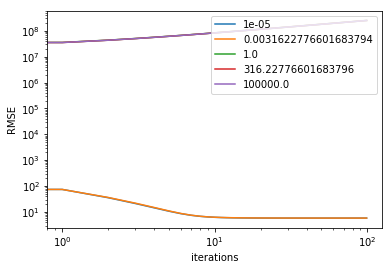

In [1226]:
for i in range(len(total_his)):
    plt.loglog(total_his[i], label=str(alpha_list[i]))
    
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.savefig('back.png')

In [1227]:
pd.DataFrame(total_his)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.151740e+02,7.465020e+01,3.579978e+01,2.148103e+01,1.457195e+01,1.078131e+01,8.655317e+00,7.477666e+00,6.829362e+00,6.466648e+00,...,5.825668e+00,5.825835e+00,5.825999e+00,5.826162e+00,5.826323e+00,5.826482e+00,5.826638e+00,5.826793e+00,5.826946e+00,5.827097e+00
1,2.126665e+02,7.456461e+01,3.652423e+01,2.213368e+01,1.500360e+01,1.103059e+01,8.786793e+00,7.545515e+00,6.869043e+00,6.497064e+00,...,5.834507e+00,5.834475e+00,5.834446e+00,5.834418e+00,5.834393e+00,5.834370e+00,5.834349e+00,5.834330e+00,5.834313e+00,5.834297e+00
2,2.507582e+07,3.565297e+07,4.372795e+07,5.052029e+07,5.649673e+07,6.189522e+07,6.685661e+07,7.147242e+07,7.580611e+07,7.990380e+07,...,2.406121e+08,2.419283e+08,2.432375e+08,2.445396e+08,2.458348e+08,2.471232e+08,2.484049e+08,2.496800e+08,2.509486e+08,2.522108e+08
3,2.490407e+07,3.537808e+07,4.340016e+07,5.015768e+07,5.610848e+07,6.148682e+07,6.643168e+07,7.103353e+07,7.535516e+07,7.944226e+07,...,2.399575e+08,2.412729e+08,2.425812e+08,2.438825e+08,2.451769e+08,2.464644e+08,2.477453e+08,2.490196e+08,2.502874e+08,2.515488e+08
4,2.490483e+07,3.537855e+07,4.340047e+07,5.015789e+07,5.610861e+07,6.148690e+07,6.643171e+07,7.103352e+07,7.535511e+07,7.944218e+07,...,2.399568e+08,2.412723e+08,2.425806e+08,2.438818e+08,2.451762e+08,2.464638e+08,2.477446e+08,2.490189e+08,2.502867e+08,2.515481e+08


In [ ]:
import matplotlib.pyplot as plt
his = []
his_train = []
alphas = np.logspace(-5, 5, 5)
min_rmse = 10000
for m in range(len(alphas)):
    for k in range(10,50,5):
        alpha = alphas[m]
        if k % 10 == 0:
            clear_output()
            
        ## take all 
        param = generate_Initial_Parameters()
        xss = param['xss']
        yss = param['yss']
        xss = xss[:,selected_var]
        X_train, X_test, Y_train, Y_test = train_test_split(xss, yss, test_size=0.2, random_state=28)
        w = gradientDescent(X_train, Y_train, alpha = alpha)
        
        val = np.column_stack(([1] * len(X_train) ,X_train))
        predict = np.dot(val,w)
        predict = np.array([round(i,0) for i in predict])
        Y_train = np.array(Y_train)

        error = (predict-Y_train)
        rmse = np.sqrt(np.mean(error**2))
        his_train.append(rmse)
        print('training rmse =', rmse, end=',')
        
        ## take the outliers out
        outlier = [ i for i in range(len(error)) if abs(error[i]) >= k]
        X_train = [ X_train[i] for i in range(len(X_train)) if i not in outlier]
        Y_train = [ Y_train[i] for i in range(len(Y_train)) if i not in outlier]
        
        w = gradientDescent(X_train, Y_train, alpha = alpha)
        val = np.column_stack(([1] * len(X_test) ,X_test))
        predict = np.dot(val,w)
        predict = np.array([round(i,0) for i in predict])
        Y_test = np.array(Y_test)
        
        error = (predict-Y_test)
        rmse = np.sqrt(np.mean(error**2))
        
        min_rmse = min(rmse, min_rmse)
        if min_rmse == rmse:
            res['w'] = w
            res['alpha'] = alpha
            res['k'] = k
            
        print('rmse =', rmse)
        his.append(rmse)

In [1421]:
file = '5hr.csv'
## read the test csv
test = pd.read_csv('data/test.csv', encoding='Big5', header=None)
test = test.replace('NR', '0')
test_feature = 18
total_test = []
row, col = test.shape
test_number = int(row/test_feature)
ans = [] 
for i in range(test_number):
    df = test.iloc[i*test_feature:(i+1)*test_feature, 2:]
    tmp = df.values.ravel().astype(np.float)    
    xs = (scaler.transform([tmp])[0])
    xs = np.array([[xs[i] for i in range(len(xs)) if i in selected_var]])[0]
#     xs = polyTransform(xs)[0]
    xs = np.concatenate(([1], xs))
    val = np.dot(xs,w)
    ans.append(["id_"+ str(i),val]) 
ans = pd.DataFrame(ans,columns=['id', 'value'])
ans.to_csv(file ,index=False)

In [1422]:
ans

,id,value
0,id_0,4.305576
1,id_1,16.828037
2,id_2,23.912270
3,id_3,6.673785
4,id_4,27.041555
5,id_5,21.848665
6,id_6,23.081605
7,id_7,29.864540
8,id_8,16.109491
9,id_9,59.919173
